# Coupled oscillations, ergodicity, and the Fermi-Pasta-Ulam problem

The vibrational modes of a crystal is a central concept in solid state physics. Coupled oscillations of nuclei underlie processes like heat conduction, sound waves, interaction with electromagnetic radiation, and heat capacity. Since there are many atoms in a macroscopic crystal (and therefore many vibrational modes), this is a problem that requires statistical mechanics --- we want to understand how the vibrational energy is distributed among the various vibrational states of the crystal. Here we will learn about a surprising problem regarding the ergodicity of a system of coupled oscillators, discovered in the early days of simulation by Fermi, Pasta, and Ulam. 

Consider a simple model for the vibrational excitations of a crystal, in which each atom is held in place by a network of springs as shown in the image.

<img src="./spring_model_crystal.gif" alt="spring lattice" width="400"/>

If an atom is displaced from its equilibrium position (say, by thermal excitation, or because you whack the edge of the crystal with a hammer), it feels a restoring force back to its equilibrium position. In the simple model shown this force is due to interactions with the neighboring atoms. There are therefore collective excitations which involve coordinated displacement of many (or even all) of the atoms in the crystal. 

If you recall your classical mechanics, these collective excitations are called "modes," and for a harmonic system of springs they are decoupled --- no energy is exchanged between different "normal modes." (They are orthogonal, after all, hence the name. We will review this in the next lecture.) This is a problem for statistical mechanics, because we need systems of many particles to be ergodic --- if we dump energy into one excitation, it must eventually find its way into other normal modes, so that the entire phase space is eventually sampled. 

For years people figured that this is no big deal, since real crystals are not perfectly harmonic. Add in a little anharmonicity, the modes get coupled, system becomes ergodic, problem solved. However, when it first was possible to try this on a computer (it's not analytically tractable) it was found that this was not the case! A few modes would be coupled, but the energy would always cycle through a *finite subset* of the normal modes. Not ergodic. This is the FPU paradox. 

It's worth noting that this is a general problem when trying to treat classical dynamical systems with statistical mechanics. A simple system which describes some sort of regular recurring orbit in phase space is not ergodic. However, a chaotic trajectory does fill phase space, as we saw in P2, and also for the damped and driven HO. So it seems reasonable to think that adding nonlinearity (and therefore making chaotic trajectories possible) should relieve the problem.

First I will explain a new integrator, and explain why it is needed to replace Euler and Euler-Cromer. Last time we reviewed coupled oscillations for harmonic systems to see that they are indeed not ergodic. Now we can introduce the nonlinearity, and see whether it restores ergodicity. 


## Basic Euler methods are not time-reversible

So far, we have seen two methods that are first-order in time: Euler and Euler-Cromer. The Euler equations for $x$ and $v$ are:

$$\begin{align}
v_{i+1} & = v_i + a_i\Delta t \\
x_{i+1} & = x_i + v_i\Delta t
\end{align}$$

We found this method to be insufficiently accurate in some cases, and so we modified it slightly to use the on-step velocity to predict the next position:

$$\begin{align}
v_{i+1} & = v_i + a_i\Delta t \\
x_{i+1} & = x_i + v_{i+1}\Delta t
\end{align}$$

Both of these methods suffer from a pair of (related) problems: (i) They are not time-reversible, and they are not symplectic (don't conserve phase space volumes). You can see that they are not time reversible by noting that if you run the trajectory in reverse, you use a *different velocity* to compute the next position, as compared to the forward running version. What we need to do is use a velocity that is intermediate between $i$ and $i+1$ to get the next position...this way when we reverse the trajectory we use the same velocity to predict the next position as we would going forward. And we need time-reversibility for the FPU problem, since the reversibility of classical trajectories is at the heart of the ergodicity problem.

## Verlet's method

To get a reversible integrator, we need to expand the equations of motion to higher order in $\Delta t$. We will do this both forwards and backwards in time, add them together so that the linear term (the not symmetric one) drops out, and voila! First for $x_{i+1}$ (using $\dot{x}$ to denote $dx/dt$, etc):

$$x_{i+1} = x_i + \dot{x}_i\Delta t + \frac{1}{2}\ddot{x}_i\Delta t^2 + \frac{1}{6}\dddot{x}_i\Delta t^3$$

And then for $x_{i-1}$:

$$x_{i-1} = x_i - \dot{x}_i\Delta t + \frac{1}{2}\ddot{x}_i\Delta t^2 - \frac{1}{6}\dddot{x}_i\Delta t^3$$

Now add the two equations. The linear *and* third order terms drop out. Solve for $x_{i+1}$:

$$\begin{align}
x_{i+1} + x_{i-1} & = 2x_i + \ddot{x}_i\Delta t^2 + O(\Delta t^4) \\
x_{i+1} & = 2x_i - x_{i-1} + \ddot{x}_i\Delta t^2 \\
x_{i+1} & = 2x_i - x_{i-1} + a_i\Delta t^2
\end{align}$$

The last line is the Verlet integrator. Knowing the current and last positions and the current acceleration (which you get from the force on patricle $i$ via $F_i/m_i$), you can predict the next position. 

Notice that we don't need the velocities to update the positions when using Verlet. It is usually a good idea to compute them, however, since some important observables depend on the velocities. We will use the velocities to compute the kinetic energy, and check that our integrator is conserving energy. (Verlet conserves energy much better than the Euler methods.) One definition for the velocity (also time-reversible, but not accurate to the same order as the positions) is

$$v_{i} = \frac{x_{i+i} - x_{i-1}}{2\Delta t}$$

## Violation of equipartition, shadow Hamiltonians, and velocity estimators

The astute reader will note that I said "one definition." Why is this? The answer is intimately related to the question, "Is equipartition of energy obtained by a molecular dynamics simulation?" You might think that this is easy to check: Just compute the energy in each quadratic degree of freedom ($mv^2/2$, etc.) and check. It turns out that if you use the (discrete) velocities from the Verlet algorithm (or indeed, any of its variants), it doesn't work! 

Recall that we should have *equipartition of energy* --- each quadratic degree of freedom should have $k_BT/2$ energy on average:

$$\begin{align}
\langle \frac{1}{2}mv^2\rangle = \frac{k_BT}{2} \\
\end{align}$$

<img src="./hot_cold_equip.jpg" alt="drawing" width="400"/>
The figure shows the temperature of the atoms in a protein (red) and the water around it (blue) during an MD simulation, obtained from the equipartition theorem. Notice that the protein is hotter than the water. This means that the average of every quadratic degree of freedom is not the same for every DoF --- equipartition is violated. What is going on here?

We need to distinguish between different definitions for the velocity. The velocity in the Verlet (or any MD) algorithm is discretized. However, the velocity that enters the Hamiltonian (and therefore is the one that you deal with when deriving equipartition) is the derivative of $x$ w.r.t. $t$ --- it is continuous. If you use the discretized velocity to compute $T$, you find that equipartition is not satisfied. If instead you use an interpolation of the positions to get a continuous function, then take its derivative to get $v$, voila --- equipartition is satisfied within the numerical accuracy of the calculation. This was only recently discovered (by the people at DESRES), and the full argument contains additional subtleties. The interested student can find more in Eastwood et al, J. Chem. Theo. Comp. 6:2045(2010). 

Last, what is this shadow Hamiltomian thing? This is one of the subtleties, which I bring out here because it is cool. Symplectic (phase space-preserving) integrators like Verlet are extremely stable, in the sense that even with relatively large time steps they don't accumulate errors in conserved quantities (viz. the flatness of the averages in the figure above). This is surprising, given that we aren't following the dynamics of the true Hamiltonian. The reason is that we *are* follwing the dynamics of a Hamiltonian, but one that is defined by the *discretized* positions and momenta. While our discrete integration doesn't do such a good job of conserving the energy, etc. of the "real" Hamiltonian, it does an excellent job of maintaining these quantitites for the *shadow Hamiltonian* that governs the evolution of the discretized positions and momenta. For quantities that depend on velocities, one has to be cautious of the distinction.

For more on shadow Hamiltonians, see Gans and Shalloway Phys Rev E 61:4587(2000).



# Verlet for a chain of coupled harmonic springs

Here we will see how to implement the Verlet integrator for a system of three equal masses and four identical springs, with the ends fixed at the walls. The equations of motion are:

$$\begin{align}
m_1\frac{d^2x_1}{dt^2} & = -k_1x_1 +k_2(x_2 - x_1) \\
m_2\frac{d^2x_2}{dt^2} & = k_2(x_1 - x_2) +k_3(x_3 - x_2) \\
m_3\frac{d^2x_3}{dt^2} & = k_3(x_2 - x_3) +k_4(x_4 - x_3) \\
\end{align}$$

It is straightforward to write the equation of motion in terms of the displacement $dx_j$ of each mass from its equilibrium position, as shown in the figure:

<img src="./masses.jpg" alt="drawing" width="300"/>

In terms of the displacements from equilibrium positions, the force on $m_2$ is

$$F_2 = -k_2(dx_2 - dx_1) -k_3(dx_2-dx_3)$$

So (big surprise), the force on any mass depends on its own displacement, as well as those of the masses to either side. Notice that if we assign a "mass" to positions $0$ and $4$, but then leave its diplacement at zero always, then the expression above works for the masses on the ends as well. 

Now set the spring constants to all be equal to one, and the force on the $j^{th}$ mass is

$$F_j = dx_{j+1} - 2dx_j + dx_{j-1}$$

Our code has three main steps:
1. Set the initial position of one (or more) of the masses perturbed from its equilibrium position.
2. Perform one integratiom step with Euler-Cromer.
3. Perform N integration steps with Verlet, using the force above

Notice that (much like in TDSE leapfrog code), we have a loop over the masses inside the Verlet integration loop.

Let's have a look at how to implement this in code.

Energy in each normal mode

6.226165884044011
2.475378711646106e-32
2.1054640782847578e-30
1.3045489243036867e-31
2.4147669735142552e-29
1.2327146490633025e-30
6.86144579619673e-30
1.0415459231901553e-30
6.807714405806316e-29
3.4904631565049e-29
2.457066691317318e-29
5.155408409961103e-31
3.9176357832461195e-30
1.4112931385635427e-29
3.430531767108075e-29
TOTAL: 6.226165884044011


Energy in each normal mode

6.225892740343517
2.4988539419919093e-27
1.6737171861352723e-27
4.301368054097446e-27
2.6756393956084253e-28
3.086040194200442e-27
1.2903202580792254e-27
7.8114813357272415e-28
7.903215343566947e-28
1.4471753646867615e-27
4.11628978002592e-28
1.2064364062332908e-27
1.5739208482609033e-27
1.020519742033832e-27
1.9968337908474738e-27
TOTAL: 6.225892740343517




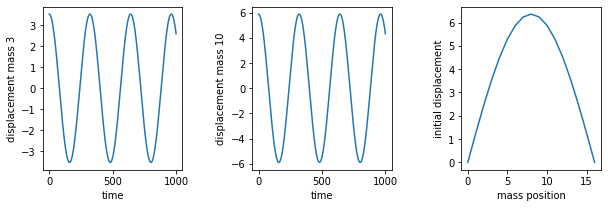

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def linear (x,x_prev,xL,xR,t2):
    x_new = 2.0*x - x_prev +(xL-2.0*x+xR)*t2
    return(x_new)


dt = 0.1
dt2 = dt**2
N_step = 1000
N_mass = 15
beta = 1.0
amp = 18.0


# the normalization of the normal modes (Eq. 10)
eig_norm = np.sqrt(2/(N_mass+1))

# I'll create a 2D array to store the displacements of the masses
# at each time step. the columns will be the masses, the rows the timesteps
# being a python neophyte, I have no idea if this is dumb.
# the structure is dX[row][column] = dx[time][mass_j]. I'll stick to using
# i for the timestep and j for the mass index

# NOTE: we include the position and velocity of the x[0] and x[N+1] "masses",
# aka the boundaries, but just initialize dX[0], dX[N+1] v[0], and v[N+1] to 0 and 
# and never update them.
# this simplifies the logic in the loops over masses, since you don't need 
# to treat the ends differently from the middle

dX = [[0.0 for j in range(0,N_mass+2)] for i in range(N_step+1)]
V = [[0.0 for j in range(0,N_mass+2)] for i in range(N_step+1)]
for i in range(N_step+1):
    #X[i][N_mass+1] = N_mass+1
    #X[i][N_mass+1] = 0.0
    dX[i][N_mass+1] = 0.0


#initialize to a chosen eigenmode "n_start" using Eq. 16 
n_start = 1
for j in range(0,N_mass+2):
    dX[0][j] = amp*eig_norm*np.sin(n_start*np.pi*j/(N_mass+1))

##########################
### VERY USEFUL DEBUG!! 
###  check whether we still only have the nth mode excited
## NOTE: the amplitudes A_n (Eq 18) will change in time, but 
## for the harmonic system they should start at zero and stay there
## if they are not excited initially
###########################

#print("Normal mode amplitudes:\n")
#for n in range(0,N_mass+2):
#    An = 0
#    for j in range(0,N_mass+2):
#        An = An + dX[0][j]*np.sin(n*np.pi*(j)/(N_mass+1))
#    An = eig_norm*An
#    print(An)
#print("\n")

#one E-C step
for j in range(1,N_mass+1):
    V[1][j] = V[0][j] + (dX[0][j-1] - 2.0*dX[0][j] + dX[0][j+1])*dt
for j in range(1,N_mass+1):
    dX[1][j] = dX[0][j] + V[1][j]*dt


##########################
### VERY USEFUL DEBUG!! 
###  check whether we still only have the nth mode excited
###########################

#print("Normal mode amplitudes:\n")
#for n in range(0,N_mass+1):
#    An = 0
#    for j in range(0,N_mass+2):
#        An = An + dX[0][j]*np.sin(n*np.pi*(j)/(N_mass+1))
#    An = eig_norm*An
#    print(An)
#print("\n")

##########################
#                        #
# now the Verlet loop    #
#                        # 
##########################

# i indexes the timestep, j indexes the mass

for i in range (2,N_step+1):
    for j in range(1,N_mass+1):
        #nonlinear version
        #dX[i][j] = 2.0*dX[i-1][j] - dX[i-2][j] + (dX[i-1][j-1] - 2.0*dX[i-1][j] + dX[i-1][j+1] 
                                                  # + beta*(dX[i-1][j+1] - dX[i-1][j])**3
                                                 # -beta*(dX[i-1][j] - dX[i-1][j-1])**3)*dt2
        
        #linear version
        dX[i][j] = linear(dX[i-1][j],dX[i-2][j],dX[i-1][j-1],dX[i-1][j+1],dt2)
        #dX[i][j] = 2.0*dX[i-1][j] - dX[i-2][j] + (dX[i-1][j-1] - 2.0*dX[i-1][j] + dX[i-1][j+1])*dt2
        
        ## MISTAKE! This should be V[i-1]
        # fixed
        V[i-1][j] = (dX[i][j] - dX[i-2][j])/(2.0*dt)

#######################################################
#                                                     #
# compute the energy in each mode: 2nd step (Eq. 19)  #
# (this should be in a subroutine)                    #
#######################################################

#check whether we still only have the nth mode excited at the last step
print("Energy in each normal mode\n")
sum = 0
for n in range(1,N_mass+1):
    An = 0
    An_dot = 0
    for j in range(1,N_mass+1):
        An = An + dX[2][j]*np.sin(n*np.pi*(j)/(N_mass+1))
        An_dot = An_dot + V[2][j]*np.sin(n*np.pi*(j)/(N_mass+1))
    omega_n = 2.0*np.absolute(np.sin(n*np.pi/(2.0*(N_mass+1))))
    En = (An_dot**2 + (omega_n*An)**2)/(N_mass+1)
    print(En)
    sum = sum + En
print("TOTAL:", sum)
print("\n")


#############################################
#                                           #
# compute the energy in each mode : last step (Eq. 19)  #
# (this should be in a subroutine)          #
#############################################

#check whether we still only have the nth mode excited at the last step
print("Energy in each normal mode\n")
sum = 0
for n in range(1,N_mass+1):
    An = 0
    An_dot = 0
    for j in range(1,N_mass+1):
        An = An + dX[N_step-1][j]*np.sin(n*np.pi*(j)/(N_mass+1))
        An_dot = An_dot + V[N_step-1][j]*np.sin(n*np.pi*(j)/(N_mass+1))
    omega_n = 2.0*np.absolute(np.sin(n*np.pi/(2.0*(N_mass+1))))
    En = (An_dot**2 + (omega_n*An)**2)/(N_mass+1)
    print(En)
    sum = sum + En
print("TOTAL:", sum)
print("\n")


##########################
### VERY USEFUL DEBUG!! 
###  check whether we still only have the nth mode excited
## NOTE: the amplitudes A_n will change in time, but 
## for the harmonic system they should start at zero and stay there
## if they are not excited initially
###########################

#print("Normal mode amplitudes:\n")
#for n in range(0,N_mass+2):
 #   An = 0
#    for j in range(0,N_mass+2):
#        An = An + dX[N_step][j]*np.sin(n*np.pi*(j)/(N_mass+1))
#    An = eig_norm*An
#    print(An)
#print("\n")



tmp_array = []
tmp_array2 = []
for i in range(0,N_step):
    tmp_array.append(dX[i][3])
    tmp_array2.append(dX[i][10])

plt.figure(1, figsize=(10, 3))
plt.subplots_adjust(wspace=0.5)
ax = plt.subplot(131)
ax.set_xlabel('time')
ax.set_ylabel('displacement mass 3')
#ax.set_xlim(right=40)
plt.plot(tmp_array)

ax2 = plt.subplot(132)
ax2.set_xlabel('time')
ax2.set_ylabel('displacement mass 10')
#ax2.set_xlim(right=40)
plt.plot(tmp_array2)

ax3 = plt.subplot(133)
ax3.set_xlabel('mass position')
ax3.set_ylabel('initial displacement')
plt.plot(dX[0])

plt.show()